Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /data/vision/torralba/scratch/sduggal/mambaforge/envs/adaptive_representations/lib/python3.10/site-packages/lpips/weights/v0.1/alex.pth
Using cached ./models


Using cache found in ./models/facebookresearch_dino_main


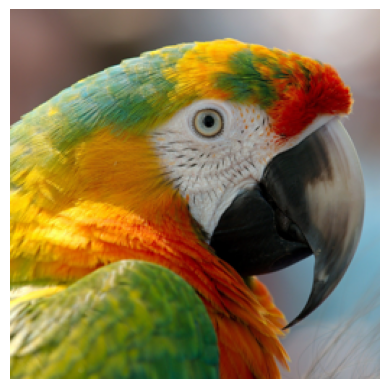

Working with z of shape (1, 16, 16, 16) = 4096 dimensions.
Loading pre-trained KL-VAE
Missing keys:
[]
Unexpected keys:
[]
Restored from base_tokenizers/pretrained_models/vae.ckpt
input tokens: 256 | approx. kolmogorov complexity: 128.0 | reconstruction l1 loss: 0.04680050536990166


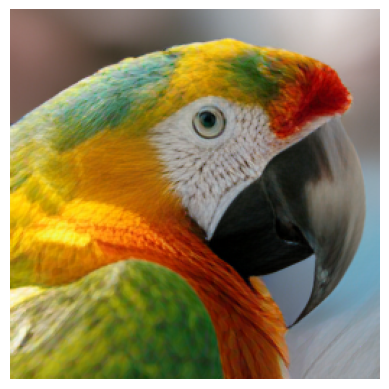

In [6]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torch
import kolmogorov_tokenizers
from utils import misc
from skimage.metrics import structural_similarity as ssim
import torchmetrics, lpips
from dreamsim import dreamsim
from torchmetrics.functional import structural_similarity_index_measure as ssim_fn

lpips_model = lpips.LPIPS(net='alex').eval().cuda()
ssim_metric = torchmetrics.image.StructuralSimilarityIndexMeasure(data_range=1.0).cuda()
psnr_metric = torchmetrics.image.PeakSignalNoiseRatio(data_range=1.0).cuda()
dreamsim_model, dreamsim_preprocess = dreamsim(pretrained=True, device="cuda")


# set arguments accordingly
args = {
    'image_path': 'assets/custom_images/000000.png',
    'device': 'cuda:4',
    'input_size': 256,
    'model': 'karl_small',
    'base_tokenizer': 'vae',
    'input_token_budget': [256],
    'desired_reconstruction_l1_epsilon': 0.05,

    'ckpt': './kolmogorov_tokenizers/pretrained_models/imagenet100/karl_small_vae_continuous_latents.pth',
    # 'ckpt': './kolmogorov_tokenizers/pretrained_models/imagenet100/karl_small_vqgan_continuous_latents.pth',
    # 'ckpt': './kolmogorov_tokenizers/pretrained_models/imagenet100/karl_small_vqgan_quantized_latents.pth',
    # 'ckpt': './kolmogorov_tokenizers/pretrained_models/imagenet/karl_small_vqgan_quantized_latents.pth',
    # 'ckpt': './kolmogorov_tokenizers/pretrained_models/imagenet100/karl_small_vqgan_quantized_latents.pth',
    'quantize_latent': False
}
args = misc.Args(**args)


image = Image.open(args.image_path).convert("RGB")
transform_val = transforms.Compose([
    transforms.Resize(args.input_size, interpolation=transforms.InterpolationMode.BICUBIC, antialias=True),
    transforms.CenterCrop(args.input_size),
    transforms.ToTensor()
])
image_tensor = transform_val(image).to(args.device)[None]
plt.imshow(image_tensor[0].permute([1,2,0]).cpu().numpy())
plt.axis('off')
plt.show()

base_tokenizer_args = {
    "id": args.base_tokenizer,
    "is_requires_grad": False
}
kolmogorov_tokenizer = kolmogorov_tokenizers.__dict__[args.model](
    base_tokenizer_args=base_tokenizer_args, quantize_latent=args.quantize_latent, 
    train_stage="full_finetuning"
)
    
kolmogorov_tokenizer.to(args.device)
checkpoint = torch.load(args.ckpt, map_location='cpu')
kolmogorov_tokenizer.load_state_dict(checkpoint['ema'], strict=False)
kolmogorov_tokenizer.eval()

with torch.no_grad():
    all_embeds, all_reconstructions, all_logs = kolmogorov_tokenizer.encode(image_tensor, input_token_budget=args.input_token_budget, desired_reconstruction_quality=args.desired_reconstruction_l1_epsilon)
    idx = 0
    for reconstruction_image in all_reconstructions:
        plt.imshow(np.clip(reconstruction_image[0].permute(1,2,0).cpu().numpy(), 0., 1.))
        plt.axis('off')
        plt.show()
        idx+=1